In [1]:
# imports
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

# Data Exploration

In [2]:
# load in dataset
df = pd.read_csv('MLB-Stats.csv')
print(df.shape)
df.head()

(28293, 28)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,RBI,SB,BB,SO,salary,IBB,HBP,SH,SF,PA
0,aardsda01,David Aardsma,215,75,R,R,2004,NL,SFN,San Francisco Giants,...,0,0,0,0,300000,0,0,0,0,0
1,aardsda01,David Aardsma,215,75,R,R,2007,AL,CHA,Chicago White Sox,...,0,0,0,0,387500,0,0,0,0,0
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0,0,0,1,403250,0,0,0,0,1
3,aardsda01,David Aardsma,215,75,R,R,2009,AL,SEA,Seattle Mariners,...,0,0,0,0,419000,0,0,0,0,0
4,aardsda01,David Aardsma,215,75,R,R,2012,AL,NYA,New York Yankees,...,0,0,0,0,500000,0,0,0,0,0


In [3]:
# check for any missing data
df.isnull().sum()

playerID       0
Player Name    0
weight         0
height         0
bats           0
throws         0
Season         0
League         0
teamID         0
Team           0
Franchise      0
G              0
AB             0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
BB             0
SO             0
salary         0
IBB            0
HBP            0
SH             0
SF             0
PA             0
dtype: int64

In [4]:
# data exploration
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,28293.0,1.990493e+02,2.265398e+01,140.0,185.0,195.0,215.0,315.0
height,28293.0,7.350019e+01,2.286595e+00,66.0,72.0,74.0,75.0,83.0
Season,28293.0,2.000938e+03,8.900551e+00,1985.0,1994.0,2001.0,2009.0,2016.0
G,28293.0,6.393387e+01,4.728526e+01,1.0,26.0,50.0,101.0,163.0
AB,28293.0,1.618799e+02,1.994066e+02,0.0,1.0,57.0,298.0,716.0
R,28293.0,2.178684e+01,3.013390e+01,0.0,0.0,4.0,37.0,152.0
H,28293.0,4.262454e+01,5.620091e+01,0.0,0.0,10.0,76.0,262.0
2B,28293.0,8.220655e+00,1.140145e+01,0.0,0.0,2.0,14.0,59.0
3B,28293.0,9.091648e-01,1.832408e+00,0.0,0.0,0.0,1.0,23.0
HR,28293.0,4.776977e+00,8.384449e+00,0.0,0.0,0.0,6.0,73.0


In [5]:
# interesting stat ideas
# avg salary by year - shows growth in cap, inflation
# total salary per team by year
# how has this changed since moneyball, statistics used to determine best value players?

In [6]:
# change column names from abbreviations to full names to help with domain knowledge
df = df.rename(columns={'G': 'Games_Played', 'AB': 'At_bats', 'R': 'Runs', 'H': 'Hits',
                   '2B': 'Doubles', '3B': 'Triples', 'HR': 'Home_Runs', 'SB': 'Stolen_Base',
                   'BB': 'Walk', 'SO': 'Strikeouts', 'IBB': 'Intentional_Walk', 'HBP': 'Hit_By_Pitch',
                   'SH': 'Sacrifice_Bunt', 'SF': 'Sacrifice_Fly', 'PA': 'Plate_Appearance'})
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance'],
      dtype='object')

# Feature Engineering

In [7]:
# batting average - hits divided by total at-bats
df['Batting_Average'] = df['Hits'] / df['At_bats']
df['Batting_Average'] = df['Batting_Average'].fillna(0)

In [8]:
# how frequently a batter reaches base per plate appearance
# times on base include hits, walks and hit-by-pitches
df['On_Base_Percentage'] = (df['Hits'] + df['Walk'] + df['Hit_By_Pitch']) / df['Plate_Appearance']
df['On_Base_Percentage'] = df['On_Base_Percentage'].fillna(0)

In [9]:
# slugging percentage = (1B + 2Bx2 + 3Bx3 + HRx4)/AB
df['Slugging_Percentage'] = ((df['Hits'] - df['Doubles'] - df['Triples'] - df['Home_Runs']) +
                             (df['Doubles'] * 2) + (df['Triples'] * 3) + (df['Home_Runs'] * 4)) / df['At_bats']
df['Slugging_Percentage'] = df['Slugging_Percentage'].fillna(0)

In [10]:
# on-base plus slugging = on-base percentage + slugging percentage
df['On_Base_Plus_Slugging'] = df['On_Base_Percentage'] + df['Slugging_Percentage']

In [11]:
# walks as a percentage of plate appearances
df['Walk_Percentage'] = df['Walk'] / df['Plate_Appearance']

In [12]:
# strikeouts as a percentage of at bats
df['Strikeout_Percentage'] = df['Strikeouts'] / df['At_bats']

In [13]:
# walk to strikeout ratio
df['Walks_To_Strikeouts'] = df['Walk'] / df['Strikeouts']
df['Walks_To_Strikeouts'] = df['Walks_To_Strikeouts'].replace([np.inf, -np.inf], 0)
df['Walks_To_Strikeouts'] = df['Walks_To_Strikeouts'].fillna(0)

In [33]:
df.isnull().sum()

playerID                    0
Player Name                 0
weight                      0
height                      0
bats                        0
throws                      0
Season                      0
League                      0
teamID                      0
Team                        0
Franchise                   0
Games_Played                0
At_bats                     0
Runs                        0
Hits                        0
Doubles                     0
Triples                     0
Home_Runs                   0
RBI                         0
Stolen_Base                 0
Walk                        0
Strikeouts                  0
Intentional_Walk            0
Hit_By_Pitch                0
Sacrifice_Bunt              0
Sacrifice_Fly               0
Plate_Appearance            0
Batting_Average             0
On_Base_Percentage          0
Slugging_Percentage      6477
On_Base_Plus_Slugging    6477
Walk_Percentage          6343
Strikeout_Percentage     6477
Walks_To_S

In [14]:
# for years in the league
# need to find a players first year
# then simply subtract the current season minus the first year to get years in the league

In [15]:
# getting oldest season for a player
year = df[['playerID', 'Season']]
year = year.rename(columns={'Season': 'Oldest_Season'})
year = year.sort_values('playerID').groupby('playerID').min()
year.head(10)

,Oldest_Season
playerID,
aardsda01,2004
aasedo01,1986
abadan01,2006
abadfe01,2011
abbotje01,1998
abbotji01,1989
abbotku01,1993
abbotky01,1992
abbotpa01,1990


In [16]:
# merging oldest season
df = df.merge(year, how='inner', on='playerID')
# determining years in the league
df['Years_In_League'] = df['Season'] - df['Oldest_Season']

In [17]:
df.head()

,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League
0,aardsda01,David Aardsma,215,75,R,R,2004,NL,SFN,San Francisco Giants,...,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,2004,0
1,aardsda01,David Aardsma,215,75,R,R,2007,AL,CHA,Chicago White Sox,...,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,2004,3
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2004,4
3,aardsda01,David Aardsma,215,75,R,R,2009,AL,SEA,Seattle Mariners,...,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,2004,5
4,aardsda01,David Aardsma,215,75,R,R,2012,AL,NYA,New York Yankees,...,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,2004,8


In [18]:
# how stats are changing from season to season?
# the average weight of players has increased from 187 in 1985 to 212 in 2016
# the average salary of players has increased from 479k in 1985 to 4.49m in 2016
df.groupby('Season').mean()

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,...,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League
Season,,,,,,,,,,,,,,,,,,,,,
1985,187.022530,73.318891,77.838821,209.284229,27.003466,54.677643,9.636049,1.417678,5.532062,25.902946,...,236.781629,0.173327,0.217251,0.325196,0.596900,0.078106,0.208826,0.479984,1985.000000,0.000000
1986,187.722581,73.329032,69.200000,177.620645,23.233548,46.061935,8.147097,1.078710,4.846452,21.867097,...,201.341935,0.165531,0.208224,0.328888,0.606162,0.076989,0.234936,0.401362,1985.345806,0.654194
1987,187.481426,73.300149,70.114413,184.178306,25.619614,48.945022,8.750371,1.120357,5.912333,24.438336,...,209.118871,0.174368,0.214620,0.332632,0.604647,0.072198,0.236182,0.407721,1985.591382,1.408618
1988,187.520509,73.333805,69.878359,186.203678,22.768034,47.612447,8.435644,1.097595,4.256011,21.555870,...,210.253182,0.164955,0.206076,0.312895,0.577421,0.071765,0.217923,0.402693,1985.881188,2.118812
1989,187.988281,73.351562,68.520833,177.423177,21.764323,45.528646,7.893229,1.096354,3.899740,20.391927,...,200.657552,0.168494,0.208437,0.317612,0.589543,0.072286,0.225745,0.404637,1986.424479,2.575521
1990,187.771300,73.357623,59.614350,149.899103,18.848655,38.823991,6.903587,0.913677,3.489910,17.822870,...,169.775785,0.154104,0.189931,0.301475,0.557781,0.066224,0.227983,0.350440,1987.181614,2.818386
1991,188.782730,73.427577,68.036212,171.235376,21.883008,44.153203,7.922006,1.101671,4.186630,20.934540,...,194.214485,0.158360,0.201263,0.304576,0.569838,0.076125,0.239627,0.381274,1987.473538,3.526462
1992,189.168553,73.398742,66.166038,167.240252,20.522013,43.031447,7.801258,0.987421,3.664151,19.323270,...,189.665409,0.161265,0.200073,0.309891,0.578697,0.072094,0.232936,0.381282,1988.108176,3.891824
1993,190.160696,73.430911,60.757421,153.820880,20.761515,40.990788,7.401228,0.930399,4.038895,19.612078,...,174.784033,0.164202,0.199621,0.326650,0.598782,0.068389,0.235728,0.351219,1989.396111,3.603889


In [19]:
# TODO - get the sum of each teams salaries for each season
# this is only for hitters not for pitchers?
df.groupby(['Season', 'Team']).sum()

weight  height  Games_Played  At_bats  Runs  \
Season Team                                                                
1985   Atlanta Braves          3964    1540          1767     4551   513   
       Baltimore Orioles       4291    1679          1911     5163   783   
       Boston Red Sox          4511    1763          1818     5185   726   
       California Angels       4792    1904          1848     4826   646   
       Chicago Cubs            4312    1700          1880     4823   603   
...                             ...     ...           ...      ...   ...   
2016   St. Louis Cardinals     6150    2129          2155     5046   699   
       Tampa Bay Rays          6767    2355          1882     4722   596   
       Texas Rangers           6816    2356          1770     4492   645   
       Toronto Blue Jays       7542    2650          2227     5398   747   
       Washington Nationals    5977    2005          2021     4992   683   

                             Hits  Doubles  Triples  Home_Runs  RBI  ...  \
Season Team                                                          ...   
1985   Atlanta Braves        1131      179       21        119  540  ...   
       Baltimore Orioles     1389      226       22        207  747  ...   
       Boston Red Sox        1478      270       28        151  712  ...   
       California Angels     1210      192       27        133  608  ...   
       Chicago Cubs          1252      213       23        141  588  ...   
...                           ...      ...      ...        ...  ...  ...   
2016   St. Louis Cardinals   1272      267       29        208  675  ...   
       Tampa Bay Rays        1167      250       30        197  570  ...   
       Texas Rangers         1189      227       17        184  630  ...   
       Toronto Blue Jays     1348      271       18        220  725  ...   
       Washington Nationals  1252      244       20        185  674  ...   

                             Plate_Appearance  Batting_Average  \
Season Team                                                      
1985   Atlanta Braves                    5149         3.695250   
       Baltimore Orioles                 5850         4.020885   
       Boston Red Sox                    5863         3.781367   
       California Angels                 5638         3.137721   
       Chicago Cubs                      5508         4.339344   
...                                       ...              ...   
2016   St. Louis Cardinals               5678         4.774930   
       Tampa Bay Rays                    5236         4.448819   
       Texas Rangers                     4965         5.099080   
       Toronto Blue Jays                 6159         4.174236   
       Washington Nationals              5707         4.964794   

                             On_Base_Percentage  Slugging_Percentage  \
Season Team                                                            
1985   Atlanta Braves                  4.565430             5.227826   
       Baltimore Orioles               5.177744             6.497565   
       Boston Red Sox                  4.552983             5.546651   
       California Angels               4.119577             4.887492   
       Chicago Cubs                    5.686459             6.224553   
...                                         ...                  ...   
2016   St. Louis Cardinals             5.972454             7.785444   
       Tampa Bay Rays                  5.610928             7.187315   
       Texas Rangers                   6.005415             9.250704   
       Toronto Blue Jays               5.481401             6.711430   
       Washington Nationals            5.931816             7.700147   

                             On_Base_Plus_Slugging  Walk_Percentage  \
Season Team                                                           
1985   Atlanta Braves                     9.793256         1.292609   
       Baltimore Orioles                 1

In [20]:
# TODO - predict the salary for a player based on their stats

In [21]:
# baseline
# how are we going to deal with a 10x increase in avg salary overtime?
# is there a way we could account for inflation?
# or could we just look one year

In [22]:
# average salary by year for all field players
avg_salary = pd.DataFrame(df['salary'].groupby(df['Season']).mean().astype(int))
avg_salary.columns = ['Avg_Salary']
avg_salary.tail()

,Avg_Salary
Season,
2012,3554070
2013,3689994
2014,3996560
2015,4418232
2016,4492526


In [23]:
# standardizing salaries 
# avg_salary['Inflation_Adj'] = 4492526 / avg_salary['Avg_Salary']
# avg_salary

In [24]:
df = df.merge(avg_salary, how='inner', on='Season')
df.head()

,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Oldest_Season,Years_In_League,Avg_Salary
0,aardsda01,David Aardsma,215,75,R,R,2004,NL,SFN,San Francisco Giants,...,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2004,0,2496285
1,abbotpa01,Paul Abbott,185,75,R,R,2004,NL,PHI,Philadelphia Phillies,...,0.181818,0.142857,0.181818,0.324675,0.000000,0.363636,0.000000,1990,14,2496285
2,abbotpa01,Paul Abbott,185,75,R,R,2004,AL,TBA,Tampa Bay Devil Rays,...,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1990,14,2496285
3,abreubo01,Bobby Abreu,220,72,L,R,2004,NL,PHI,Philadelphia Phillies,...,0.301394,0.421853,0.543554,0.965407,0.175657,0.202091,1.094828,1997,7,2496285
4,acevejo01,Jose Acevedo,185,72,R,R,2004,NL,CIN,Cincinnati Reds,...,0.046512,0.096154,0.046512,0.142665,0.057692,0.604651,0.115385,2002,2,2496285


In [25]:
# df['Inflation_Adj_Salary'] = (df['salary'] * df['Inflation_Adj']).astype(int)
# df.head()

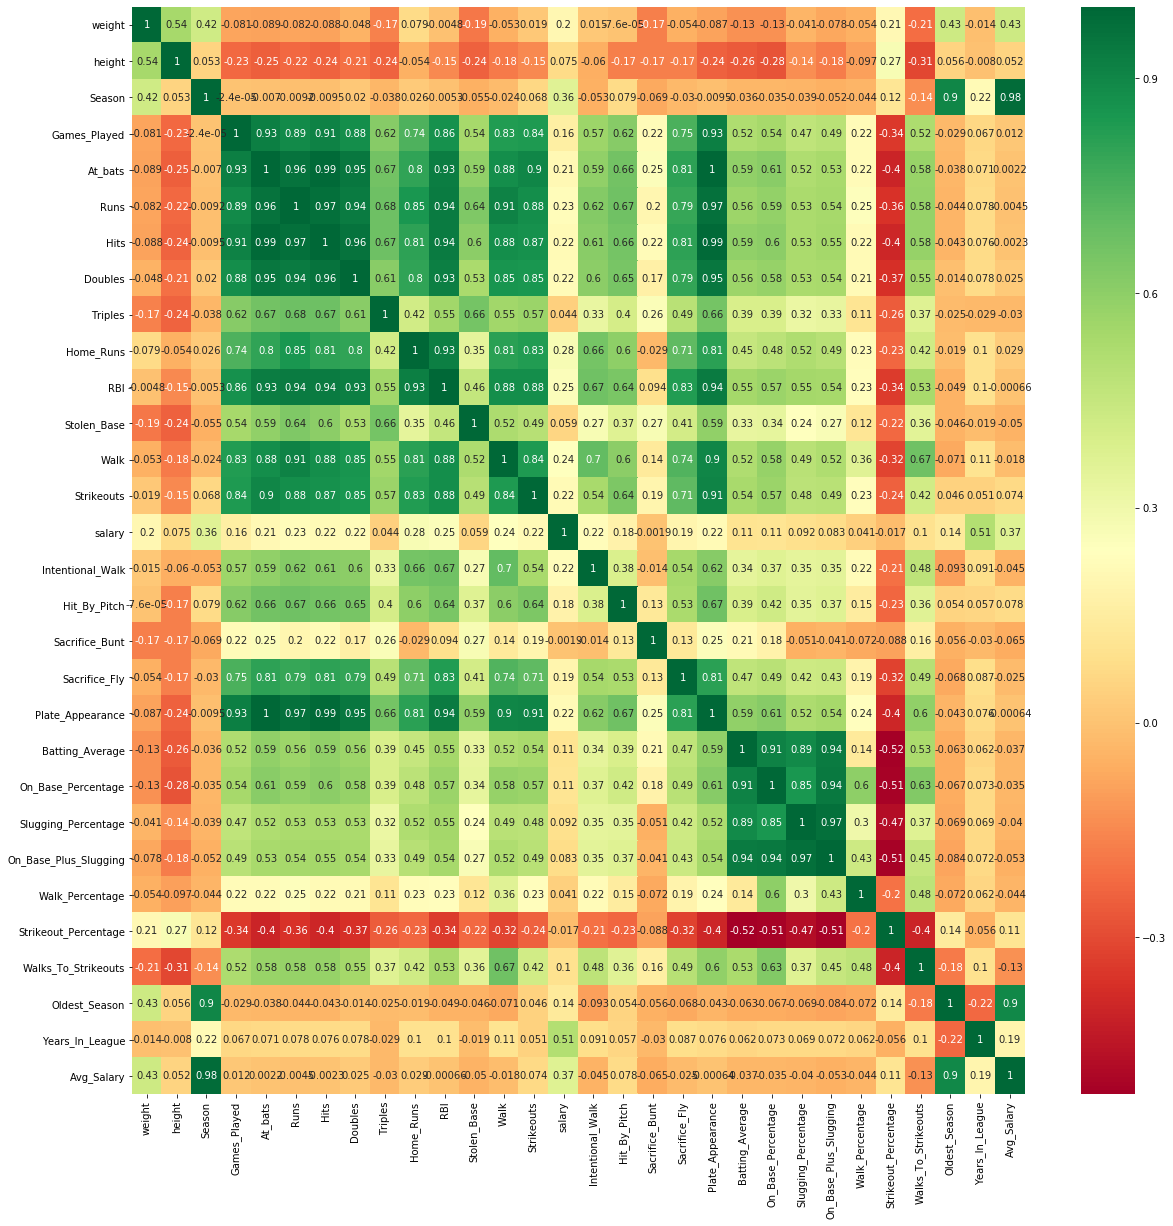

In [26]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [27]:
# df = df[df.Season == 1985]

In [28]:
# mean absolute error
errors = df['Avg_Salary'] - df['salary']
mean_absolute_error = errors.abs().mean()
print(f"""If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of ${mean_absolute_error:,.0f}""")

If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of $2,031,353


In [29]:
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance',
       'Batting_Average', 'On_Base_Percentage', 'Slugging_Percentage',
       'On_Base_Plus_Slugging', 'Walk_Percentage', 'Strikeout_Percentage',
       'Walks_To_Strikeouts', 'Oldest_Season', 'Years_In_League',
       'Avg_Salary'],
      dtype='object')

In [30]:
# features
features = [
 'Season',
 'Games_Played',
 'At_bats',
 'Runs',
 'Hits',
 'Doubles',
 'Home_Runs',
 'RBI',
 'Walk',
 'Strikeouts',
 'Intentional_Walk',
 'Plate_Appearance',
 'On_Base_Percentage',
 'Batting_Average',
 'Slugging_Percentage',
 'On_Base_Plus_Slugging',
 'Walk_Percentage',
 'Strikeout_Percentage',
 'Walks_To_Strikeouts',
 'Years_In_League']

# shuffle data
df = shuffle(df)
# drop target
y = df.pop('salary')
X = df[features]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((16975, 20), (5659, 20), (5659, 20), (16975,), (5659,), (5659,))

In [31]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();

In [ ]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    KNeighborsRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RandomForestRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
Season = 2016
Games_Played = 120
At_bats = 170
Runs = 25
Hits = 100
Doubles = 8
Home_Runs = 50
RBI = 100
Walk = 20
Strikeouts = 30
Intentional_Walk = 2
Plate_Appearance = 180
On_Base_Percentage = .400
Batting_Average = .300
Slugging_Percentage = .500
On_Base_Plus_Slugging = .900
Walk_Percentage = .10
Strikeout_Percentage = .30
Walks_To_Strikeouts = .20
Years_In_League = 1

X_test = [[
 Season,
 Games_Played,
 At_bats,
 Runs,
 Hits,
 Doubles,
 Home_Runs,
 RBI,
 Walk,
 Strikeouts,
 Intentional_Walk,
 Plate_Appearance,
 On_Base_Percentage,
 Batting_Average,
 Slugging_Percentage,
 On_Base_Plus_Slugging,
 Walk_Percentage,
 Strikeout_Percentage,
 Walks_To_Strikeouts,
 Years_In_League]]

y_pred = pipeline.predict(X_test)
y_pred